## 🎯 なぜカスタム関数が必要か

### Wandasの標準機能だけでは足りない場合

Wandasには豊富な信号処理機能が組み込まれていますが、
実際のプロジェクトでは以下のようなニーズが生じます：

1. **独自のアルゴリム**: 研究開発や特殊な分析手法
2. **ドメイン固有の処理**: 業界特有の計算や変換
3. **プロトタイピング**: 新しい処理を試す前段階
4. **統合**: 既存のNumPy/SciPy関数を組み込む

### `apply()` メソッドの利点

- **統一されたインターフェース**: 標準機能と同じように使える
- **メタデータの自動管理**: サンプリングレートや処理履歴を保持
- **遅延評価対応**: Daskによる効率的な処理
- **メソッドチェーン可能**: 他の処理と組み合わせやすい

## 📦 準備

In [13]:
# 必要なライブラリをインポート
import wandas as wd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import japanize_matplotlib
# プロット設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Wandas: {wd.__version__}")
print("✅ 準備完了")

Wandas: 0.1.10
✅ 準備完了


In [14]:
# デモ用の信号を作成
np.random.seed(42)
sampling_rate = 1000  # 1kHz
duration = 2.0
time = np.linspace(0, duration, int(duration * sampling_rate))

# 複数の周波数成分を持つ信号
signal_data = (
    1.0 * np.sin(2 * np.pi * 50 * time) +   # 50Hz
    0.7 * np.sin(2 * np.pi * 120 * time) +  # 120Hz
    0.5 * np.sin(2 * np.pi * 200 * time) +  # 200Hz
    0.1 * np.random.randn(len(time))        # ノイズ
)

# ChannelFrameを作成
demo_signal = wd.from_numpy(
    data=signal_data.reshape(1, -1),
    sampling_rate=sampling_rate,
    ch_labels=['Demo Signal']
)

print(f"デモ信号作成完了:")
print(f"  サンプリングレート: {demo_signal.sampling_rate} Hz")
print(f"  信号長: {demo_signal.duration:.2f} 秒")
print(f"  サンプル数: {demo_signal.n_samples}")

デモ信号作成完了:
  サンプリングレート: 1000 Hz
  信号長: 2.00 秒
  サンプル数: 2000


## 🔰 基本的な使い方

### 最もシンプルな例：スケーリング

`apply()` メソッドの基本構文：

```python
result = frame.apply(func, **params)
```

- `func`: 適用する関数（第1引数は配列）
- `**params`: 関数に渡す追加パラメータ

In [15]:
# 例1: シンプルなスケーリング関数
def scale(x, factor):
    """信号を指定倍率でスケーリング"""
    return x * factor

# カスタム関数を適用（2倍にスケール）
scaled = demo_signal.apply(
    scale,
    output_shape_func=lambda shape: shape,  # 出力形状は入力と同じ
    factor=2.0
)

print("スケーリング適用:")
print(f"  元の信号の最大値: {demo_signal.compute().max():.3f}")
print(f"  スケール後の最大値: {scaled.compute().max():.3f}")
print(f"  チャンネルラベル: {scaled.labels}")

スケーリング適用:
  元の信号の最大値: 2.184
  スケール後の最大値: 4.368
  チャンネルラベル: ['scale(Demo Signal)']


## 📐 出力形状の制御

### `output_shape_func` パラメータ

カスタム関数を使う際、`output_shape_func`で出力形状を指定することでパフォーマンスが向上します。   
`output_shape_func`は、入力形状を受け取り、出力形状を返す関数です。   
指定しない場合、Wandasは自動推論を試みますが、関数を実行するためのコストがかかります。   

```python

# 自動推論（関数が1回実行される）
result = demo_signal.apply(some_func)

# 明示的に指定（推奨：推論コストを回避）
result = demo_signal.apply(
    some_func,
    output_shape_func=lambda shape: shape
)

**なぜ必要？**
- Daskの遅延評価では、実際に計算する前に出力形状を知る必要がある
- 効率的なメモリ管理とタスクグラフ構築のため

In [16]:
# 例2: ダウンサンプリング（サンプル数を半分に）
def downsample_by_half(x):
    """偶数インデックスのサンプルのみを返す"""
    return x[:, ::2]

# 出力形状を計算する関数
def half_shape(input_shape):
    """入力形状から出力形状を計算"""
    channels, samples = input_shape
    return (channels, samples // 2)

# カスタムダウンサンプリングを適用
downsampled = demo_signal.apply(
    downsample_by_half,
    output_shape_func=half_shape
)

print("ダウンサンプリング適用:")
print(f"  元のサンプル数: {demo_signal.n_samples}")
print(f"  ダウンサンプル後: {downsampled.n_samples}")
print(f"  チャンネルラベル: {downsampled.labels}")

ダウンサンプリング適用:
  元のサンプル数: 2000
  ダウンサンプル後: 1000
  チャンネルラベル: ['downsample_by_half(Demo Signal)']


## 🔗 既存ライブラリとの統合

### SciPyの関数を組み込む

SciPyなど既存のライブラリの関数も `apply()` で簡単に使えます。

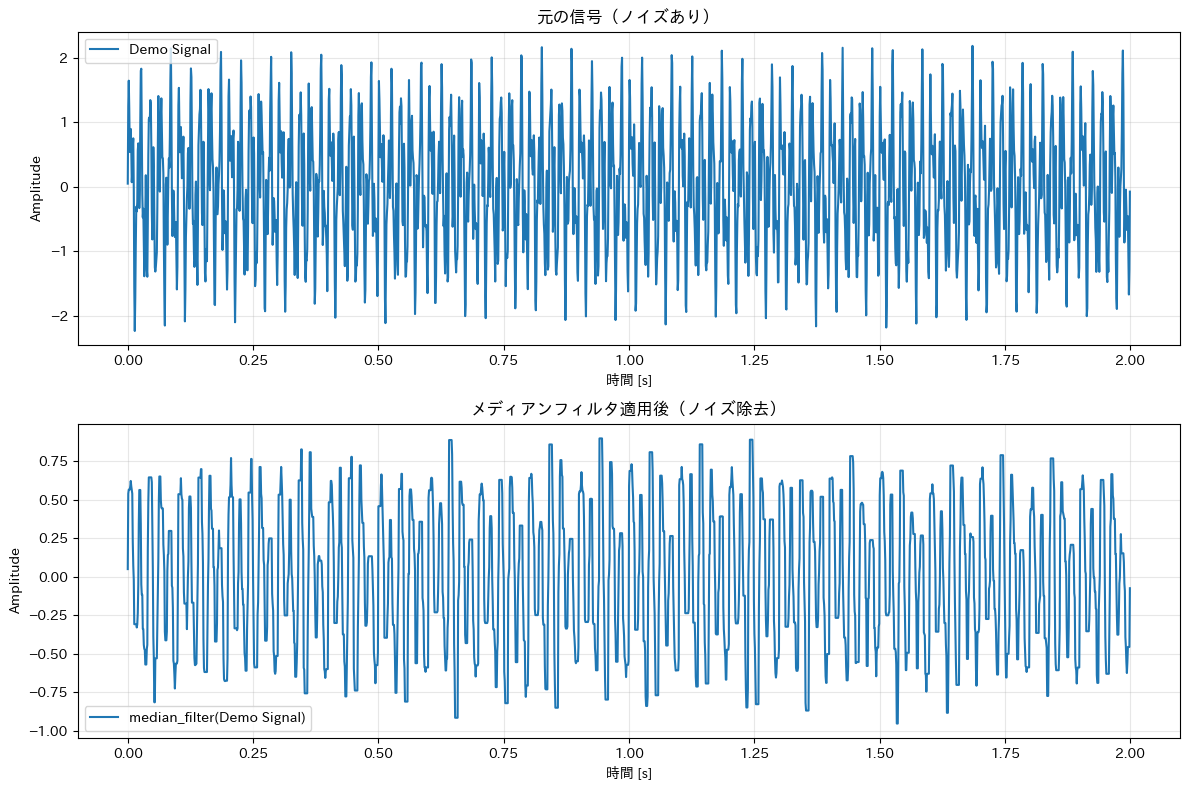

メディアンフィルタ適用完了
  チャンネルラベル: ['median_filter(Demo Signal)']


In [17]:
# 例3: SciPyのメディアンフィルタを使う
def median_filter(x, kernel_size):
    """メディアンフィルタを各チャンネルに適用"""
    result = scipy_signal.medfilt(x, kernel_size=(1, kernel_size))
    return result

# メディアンフィルタを適用（ノイズ除去）
filtered = demo_signal.apply(
    median_filter,
    output_shape_func=lambda shape: shape,
    kernel_size=11
)

# 結果を比較
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# 元の信号
demo_signal.plot(ax=axes[0], time_range=(0, 0.2))
axes[0].set_title('元の信号（ノイズあり）')
axes[0].set_xlabel('時間 [s]')
axes[0].grid(True, alpha=0.3)

# フィルタ後
filtered.plot(ax=axes[1], time_range=(0, 0.2))
axes[1].set_title('メディアンフィルタ適用後（ノイズ除去）')
axes[1].set_xlabel('時間 [s]')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("メディアンフィルタ適用完了")
print(f"  チャンネルラベル: {filtered.labels}")

## ⛓️ メソッドチェーンへの統合

### カスタム関数も標準機能と組み合わせられる

`apply()` の戻り値は通常の `ChannelFrame` なので、
他のメソッドと自由にチェーンできます。

複数処理のチェーン適用:
  処理履歴の長さ: 3
  最終チャンネルラベル: ['lpf(norm(clip_amplitude(Demo Signal)))']

処理履歴:
  1. custom - {'threshold': 0.5}
  2. normalize - {'norm': inf, 'axis': -1, 'threshold': None, 'fill': None}
  3. lowpass_filter - {'cutoff': 150, 'order': 4}


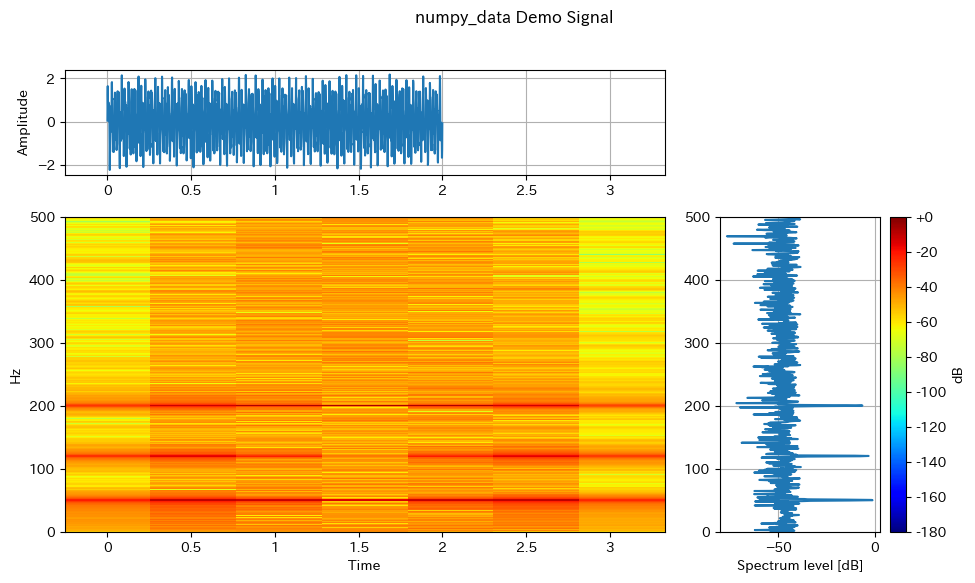

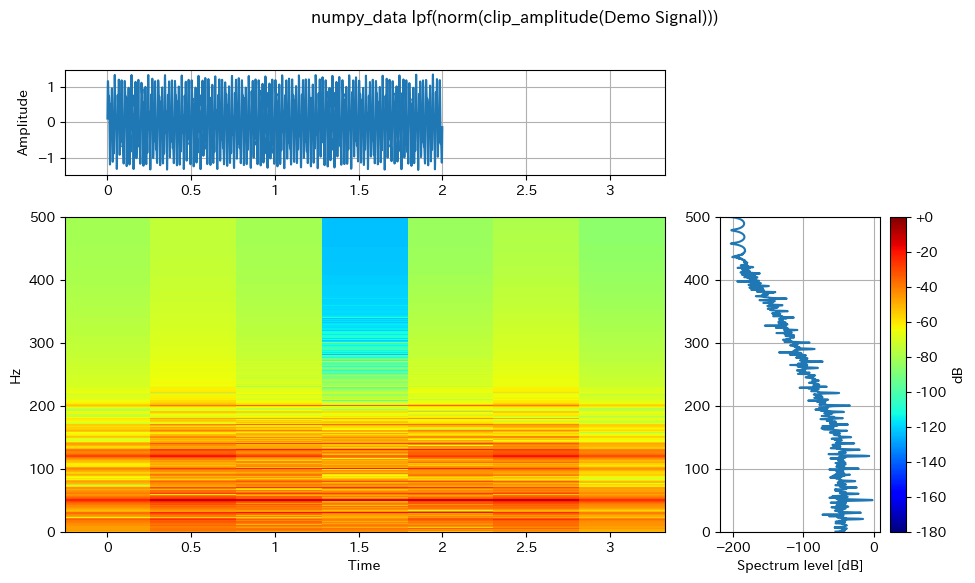

In [18]:
# 例4: カスタム関数と標準機能を組み合わせる
def clip_amplitude(x, threshold):
    """振幅を指定値でクリップ"""
    return np.clip(x, -threshold, threshold)

# メソッドチェーン：カスタム関数 → 正規化 → ローパスフィルタ
processed = (demo_signal
    .apply(
        clip_amplitude,
        output_shape_func=lambda shape: shape,
        threshold=0.5
    )
    .normalize()
    .low_pass_filter(cutoff=150)
)

print("複数処理のチェーン適用:")
print(f"  処理履歴の長さ: {len(processed.operation_history)}")
print(f"  最終チャンネルラベル: {processed.labels}")
print("\n処理履歴:")
for i, op in enumerate(processed.operation_history, 1):
    print(f"  {i}. {op['operation']} - {op.get('params', {})}")

demo_signal.describe()
processed.describe()

## 🚀 実践的な例

### 例1: 移動平均フィルタ

シンプルですが実用的な移動平均フィルタを実装します。

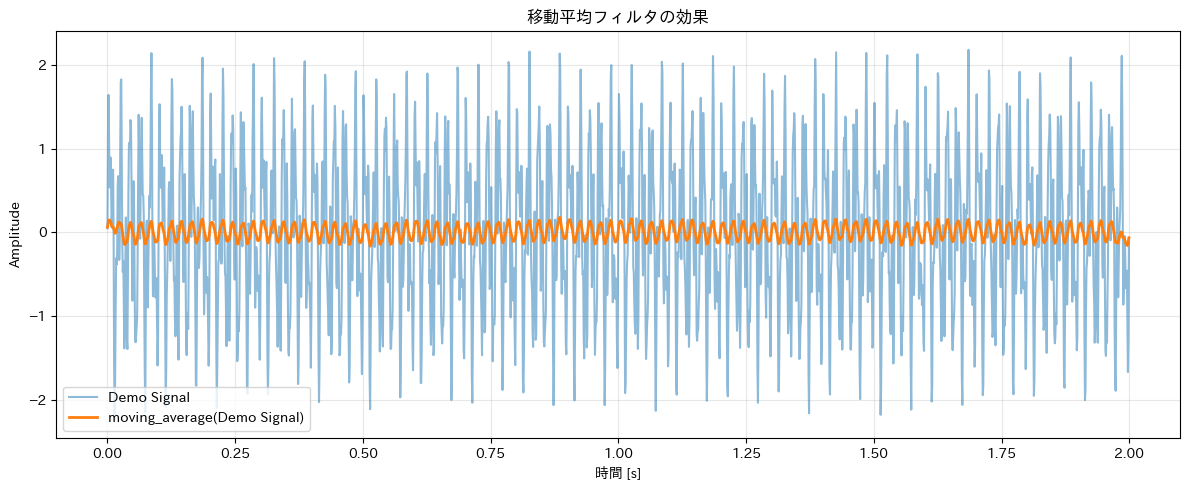

移動平均フィルタ適用完了


In [19]:
def moving_average(x, window_size):
    """移動平均フィルタ"""
    result = np.zeros_like(x)
    for i in range(x.shape[0]):
        # 畳み込みで移動平均を計算
        kernel = np.ones(window_size) / window_size
        result[i] = np.convolve(x[i], kernel, mode='same')
    return result

# 移動平均を適用
smoothed = demo_signal.apply(
    moving_average,
    output_shape_func=lambda shape: shape,
    window_size=51  # 51サンプルの窓
)

# 結果を可視化
fig, ax = plt.subplots(figsize=(12, 5))
demo_signal.plot(ax=ax, time_range=(0.5, 1.0), label='元の信号', alpha=0.5)
smoothed.plot(ax=ax, time_range=(0.5, 1.0), label='移動平均適用後', linewidth=2)
ax.set_title('移動平均フィルタの効果')
ax.set_xlabel('時間 [s]')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("移動平均フィルタ適用完了")

### 例2: エンベロープ抽出

信号のエンベロープ（包絡線）を抽出します。

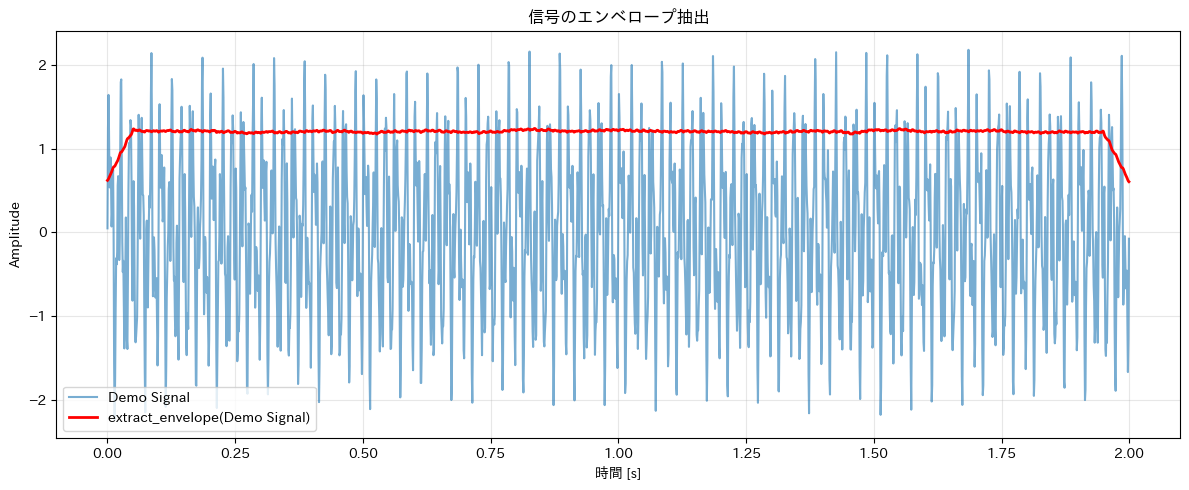

エンベロープ抽出完了
  チャンネルラベル: ['extract_envelope(Demo Signal)']


In [20]:
def extract_envelope(x, window_size):
    """Hilbert変換によるエンベロープ抽出"""
    from scipy.signal import hilbert

    result = np.zeros_like(x)
    for i in range(x.shape[0]):
        # Hilbert変換で解析信号を取得
        analytic_signal = hilbert(x[i])
        # 振幅（エンベロープ）を計算
        envelope = np.abs(analytic_signal)
        # 移動平均でスムージング
        kernel = np.ones(window_size) / window_size
        result[i] = np.convolve(envelope, kernel, mode='same')
    return result

# エンベロープを抽出
envelope = demo_signal.apply(
    extract_envelope,
    output_shape_func=lambda shape: shape,
    window_size=101
)

# 可視化
fig, ax = plt.subplots(figsize=(12, 5))
demo_signal.plot(ax=ax, label='元の信号', alpha=0.6)
envelope.plot(ax=ax, label='エンベロープ', linewidth=2, color='red')
ax.set_title('信号のエンベロープ抽出')
ax.set_xlabel('時間 [s]')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("エンベロープ抽出完了")
print(f"  チャンネルラベル: {envelope.labels}")

### 例3: カスタムゲイン関数

周波数依存のゲインカーブを適用します。

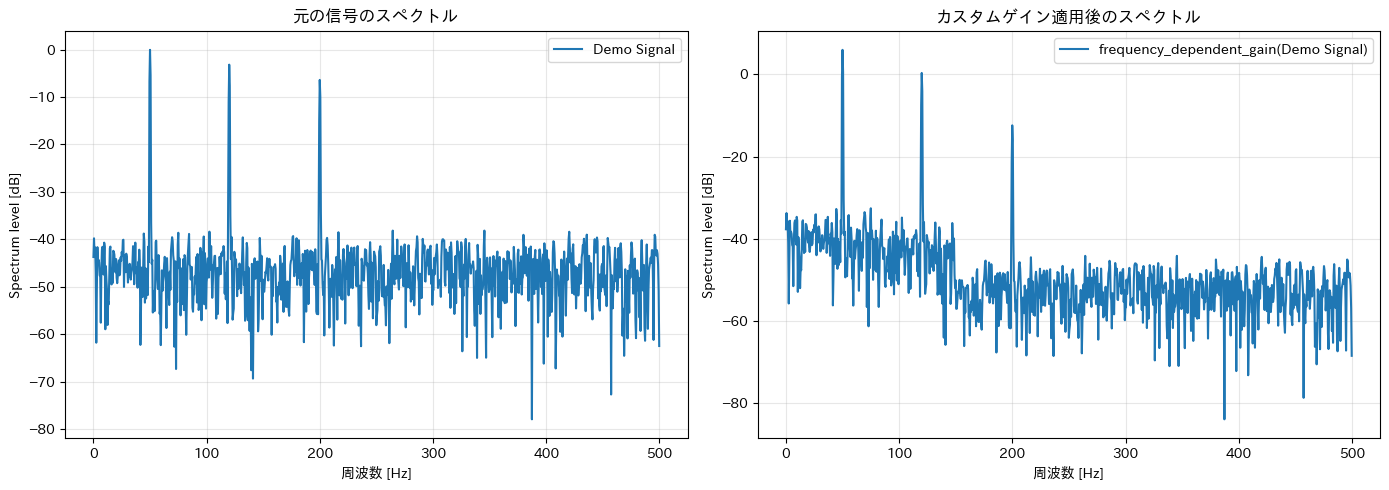

カスタムゲイン適用完了
  低周波（<80Hz）を2倍に強調
  中周波（80-150Hz）を1.5倍に強調
  高周波（>150Hz）を0.5倍に減衰


In [21]:
def frequency_dependent_gain(x, sr, gain_curve):
    """
    周波数依存のゲインを適用

    Parameters
    ----------
    x : ndarray
        入力信号
    sr : float
        サンプリングレート（Wandasから自動取得不可のため明示的に渡す）
    gain_curve : callable
        周波数を受け取りゲインを返す関数
    """
    result = np.zeros_like(x, dtype=complex)

    # FFT
    spectrum = np.fft.rfft(x, axis=1)
    freqs = np.fft.rfftfreq(x.shape[1], d=1/sr)

    # ゲインカーブを適用（ベクトル化）
    gains = np.array([gain_curve(f) for f in freqs])
    spectrum *= gains[np.newaxis, :]  # ブロードキャストで全チャンネルに適用

    # 逆FFT
    result = np.fft.irfft(spectrum, n=x.shape[1], axis=1)

    return result.real

# ゲインカーブを定義（低周波を強調）
def low_freq_emphasis(freq):
    """低周波を強調するゲインカーブ"""
    if freq < 80:
        return 2.0
    elif freq < 150:
        return 1.5
    else:
        return 0.5

# カスタムゲインを適用
gained = demo_signal.apply(
    frequency_dependent_gain,
    output_shape_func=lambda shape: shape,
    sr=sampling_rate,  # サンプリングレートを明示的に渡す
    gain_curve=low_freq_emphasis
)

# スペクトルで比較
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 元の信号のスペクトル
demo_signal.fft().plot(ax=axes[0], freq_range=(0, 300))
axes[0].set_title('元の信号のスペクトル')
axes[0].set_xlabel('周波数 [Hz]')
axes[0].grid(True, alpha=0.3)

# ゲイン適用後のスペクトル
gained.fft().plot(ax=axes[1], freq_range=(0, 300))
axes[1].set_title('カスタムゲイン適用後のスペクトル')
axes[1].set_xlabel('周波数 [Hz]')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("カスタムゲイン適用完了")
print("  低周波（<80Hz）を2倍に強調")
print("  中周波（80-150Hz）を1.5倍に強調")
print("  高周波（>150Hz）を0.5倍に減衰")

## 💡 ベストプラクティス

### 1. 出力形状は明示的に指定する

```python
# ❌ 推奨しない：形状推論に頼る
result = frame.apply(some_func)

# ✅ 推奨：明示的に指定
result = frame.apply(
    some_func,
    output_shape_func=lambda shape: shape
)
```

**理由**: 形状推論は関数を1回実行するため、副作用がある関数や重い処理では問題になる可能性があります。

### 2. 関数に名前を付ける

```python
# ❌ 推奨しない：ラムダ式
result = frame.apply(lambda x: x * 2, output_shape_func=lambda s: s)

# ✅ 推奨：名前付き関数
def double(x):
    return x * 2

result = frame.apply(double, output_shape_func=lambda s: s)
```

**理由**: チャンネルラベルに関数名が表示され、処理履歴が分かりやすくなります。

### 3. パラメータは明示的に渡す

```python
# ❌ 推奨しない：グローバル変数を参照
threshold = 1.5
def clip(x):
    return np.clip(x, -threshold, threshold)

# ✅ 推奨：パラメータとして渡す
def clip(x, threshold):
    return np.clip(x, -threshold, threshold)

result = frame.apply(clip, output_shape_func=lambda s: s, threshold=1.5)
```

**理由**: パラメータが処理履歴に記録され、再現性が向上します。

### 4. 配列の形状に注意

```python
# Wandasの配列形状は (channels, samples)
def process_each_channel(x):
    result = np.zeros_like(x)
    for i in range(x.shape[0]):  # チャンネルごとにループ
        result[i] = some_operation(x[i])
    return result
```

### 5. ドキュメンテーション

```python
def custom_filter(x, cutoff, order):
    """
    カスタムフィルタを適用
    
    Parameters
    ----------
    x : ndarray, shape (channels, samples)
        入力信号
    cutoff : float
        カットオフ周波数 [Hz]
    order : int
        フィルタ次数
    
    Returns
    -------
    ndarray
        フィルタ適用後の信号
    """
    # 実装...
```

## ⚠️ 制限事項と注意点

### 1. サンプリングレートへのアクセス

カスタム関数内からはサンプリングレートに直接アクセスできません。
必要な場合はパラメータとして渡してください。

```python
def needs_sr(x, sr):
    # sampling_rateを使った処理
    pass

result = frame.apply(
    needs_sr,
    output_shape_func=lambda s: s,
    sr=frame.sampling_rate
)
```

### 2. メタデータの更新

カスタム関数はサンプリングレートを変更できません。
リサンプリングが必要な場合は `  ChannelFrame.resample()` メソッドを使用してください。

### 3. 複数チャンネルの処理

チャンネル数を変更する処理（例：ステレオ→モノラル変換）は、
`output_shape_func` で正しい形状を返すようにしてください。

## 🔁 別のFrame型へ変換したいとき：`transform()`

`apply()` は **同じFrame型（例: ChannelFrame -> ChannelFrame）を返す** ためのAPIです。
一方で、FFT/STFTのように **別のFrame型へ変換したい** 場合があります（例: ChannelFrame -> SpectralFrame）。
そのために `transform()` を使います。

基本形：

```python
result = frame.transform(
    func,
    out=OutFrameClass,
    out_kwargs={...},
    output_shape_func=...,      # 推奨（lazyを安定させる）
    output_dtype=...,           # 推奨（real -> complex など）
    **params,
)
```

### 重要ポイント

- `out`: 出力にしたいFrameクラス（例: `wd.SpectralFrame`）
- `out_kwargs`: 出力Frameの初期化に必要な追加引数（例: `n_fft`, `window` など）
- `output_shape_func`: **出力形状を明示**する関数（推奨）
- `infer_output_shape`（既定 `True`）: `output_shape_func` が無い場合に限り、**小さなNumPy配列で1回だけdry-run**して形状を推論します
  - 注意: dry-runがあると、関数が「余計に1回」呼ばれます（副作用がある関数には不向き）
- `output_dtype`: dtypeが変わる変換（例: FFTでcomplexになる）では、**明示指定**が安全です


labels: ['rfft_transform(Demo Signal)']
history last: {'operation': 'custom', 'params': {'n_fft': 1024}}


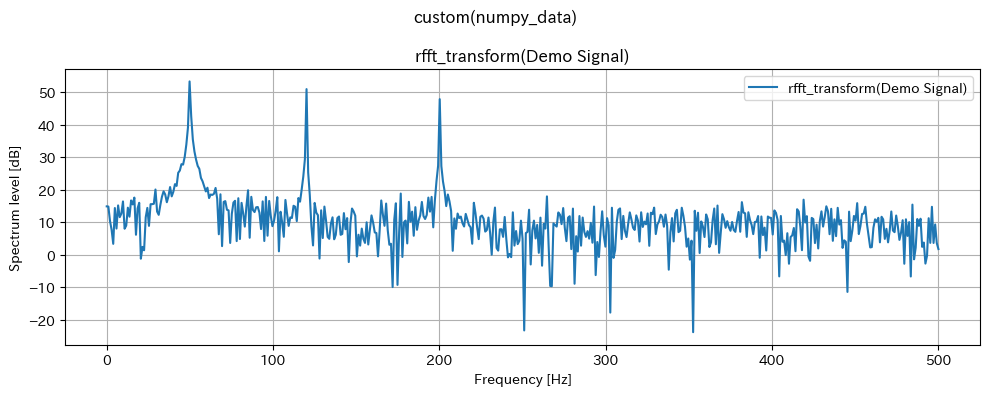

In [22]:
# 例: rFFTで SpectralFrame に変換する
from wandas.frames import SpectralFrame

# rFFT: (channels, samples) -> (channels, n_fft//2 + 1) で complex になる
def rfft_transform(x: np.ndarray, n_fft: int) -> np.ndarray:
    return np.fft.rfft(x, n=n_fft, axis=1)

n_fft = 1024

spec = demo_signal.transform(
    rfft_transform,
    out=SpectralFrame,
    out_kwargs={"n_fft": n_fft, "window": "hann"},
    output_shape_func=lambda s: (s[0], n_fft // 2 + 1),  # 推奨: 形状を明示
    output_dtype=np.complex128,  # 推奨: dtypeを明示
    n_fft=n_fft,
 )

print(spec)
print("labels:", spec.labels)
print("history last:", spec.operation_history[-1])
spec.plot()

### 例: STFTで `SpectrogramFrame` に変換する（時間-周波数）

`SpectrogramFrame` は通常、STFTの設定（`n_fft`, `hop_length`, `win_length`, `window`, `center`, `pad_mode` など）を保持します。
`transform()` では **出力Frameの初期化に必要な引数は `out_kwargs` で渡す** 点に注意してください。

また、STFTの出力は一般に shape が `(channels, n_freq, n_time)` になり、`n_time` は `center/pad_mode/hop_length` で変わりやすいので、ビギナー向けには `infer_output_shape=True`（既定）で dry-run に任せるのが簡単です。

- 速くて安全: `output_shape_func` を自前で用意
- 手軽: `infer_output_shape=True` で dry-run（関数が余計に1回呼ばれる）


Frame transform inferred output shape via dry-run. For performance and safety, provide output_shape_func.


shape: (513, 1)


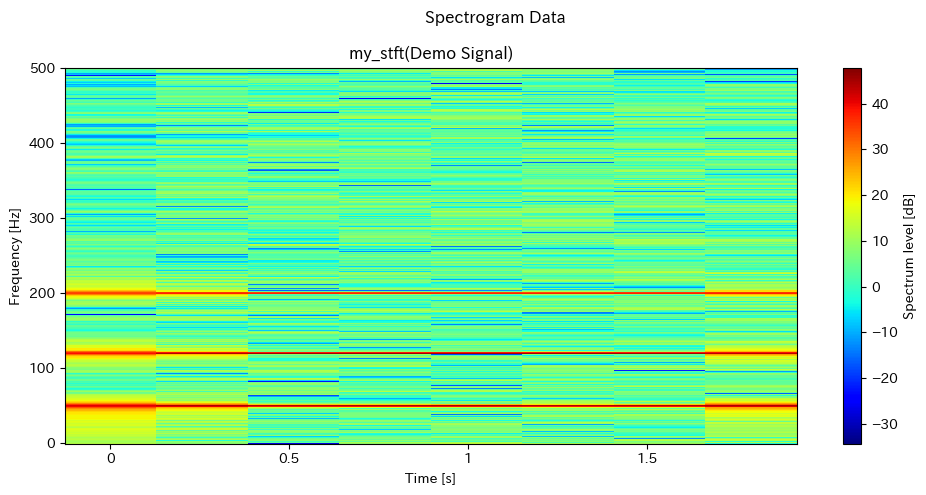

In [23]:
# 例: STFT相当の変換を自作して SpectrogramFrame にする
from wandas.frames import SpectrogramFrame

# 注意: ここでは librosa.stft を使った簡単な例です（SciPyでもOK）
import librosa

def my_stft(
    x: np.ndarray,
    *,
    n_fft: int,
    hop_length: int,
    win_length: int,
    window: str,
    center: bool,
    pad_mode: str,
 ) -> np.ndarray:
    # x: (channels, samples) -> (channels, freq, time)
    stfts = []
    for ch in x:
        s = librosa.stft(
            ch,
            n_fft=n_fft,
            hop_length=hop_length,
            win_length=win_length,
            window=window,
            center=center,
            pad_mode=pad_mode,
        )
        stfts.append(s)
    return np.stack(stfts, axis=0)

n_fft = 1024
hop_length = 256
win_length = 1024
window = "hann"
center = True
pad_mode = "constant"

# `out_kwargs` は SpectrogramFrame の __init__ が受け取れるものだけ渡す
#   SpectrogramFrame(data, sampling_rate, n_fft, hop_length, win_length=None, window="hann", ...)
specgram = demo_signal.transform(
    my_stft,
    out=SpectrogramFrame,
    out_kwargs={
        "n_fft": n_fft,
        "hop_length": hop_length,
        "win_length": win_length,
        "window": window,
    },
    # ビギナー向け: 時間フレーム数は計算がやや面倒なのでdry-run推論に任せる
    infer_output_shape=True,
    # STFTは complex になることが多いので明示しておくと安全
    output_dtype=np.complex128,
    # ここから下は `my_stft` に渡すパラメータ（SpectrogramFrameには渡さない）
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    center=center,
    pad_mode=pad_mode,
 )

print(specgram)
print("shape:", specgram.shape)
specgram.plot()

## 📝 まとめ

このノートブックでは、以下を学びました：

✅ **`apply()` メソッドの基本的な使い方**
- カスタム関数を信号処理パイプラインに統合
- パラメータの渡し方

✅ **出力形状の制御**
- `output_shape_func` による明示的な形状指定
- ダウンサンプリングなど形状が変わる処理への対応

✅ **既存ライブラリとの統合**
- SciPyなど外部ライブラリの関数を組み込む
- NumPy/SciPyの豊富な機能を活用

✅ **メソッドチェーン**
- カスタム関数と標準機能を自由に組み合わせ
- 処理履歴の自動記録

✅ **実践的な例**
- 移動平均、エンベロープ抽出、周波数依存ゲイン
- ベストプラクティスと注意点


カスタム関数を活用することで、Wandasの機能を自由に拡張できます！